In [33]:
import os
import re

import tempfile
import tensorflow as tf
import numpy as np
import pandas as pd
import sys

from tensorflow.python.keras.datasets import imdb #imdb dataset
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import utils

import tensorflow_hub as hub
from tensorboard import summary as summary_lib

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = tempfile.mkdtemp()

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

BATCH_SIZE = 128

In [3]:
dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

84131840/84125825 [==============================] - 15s 0us/step


In [5]:
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [10]:
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
            
    return pd.DataFrame.from_dict(data)

In [15]:
train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

In [16]:
train_df.head()

,sentence,sentiment,polarity
0,I don't what that other review was talking abo...,1,0
1,This movie shows a clip of live animal mutilat...,1,0
2,"Thank God this wasn't based on a true story, b...",8,1
3,This is not an entirely bad movie. The plot (n...,4,0
4,I simply can't get over how brilliant the pair...,9,1


In [17]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

In [21]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [22]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz1qn0cm1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f958d0750b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
estimator.train(input_fn=train_input_fn, steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz1qn0cm1/model.ckpt.
INFO:tensorflow:loss = 90.58795, step = 1
INFO:tensorflow:global_step/sec: 75.4076
INFO:tensorflow:loss = 60.159256, step = 101 (1.327 sec)
INFO:tensorflow:global_step/sec: 79.0999
INFO:tensorflow:loss = 60.51197, step = 201 (1.264 sec)
INFO:tensorflow:global_step/sec: 78.3636
INFO:tensorflow:loss = 58.571663, step = 301 (1.276 sec)
INFO:tensorflow:global_step/sec: 78.3829
INFO:tensorflow:loss = 55.559357, step = 401 (1.276 sec)
INFO

In [26]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-05-07:36:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz1qn0cm1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-05-07:36:25
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.80144, accuracy_baseline = 0.5, auc = 0.8838076, auc_precision_recall = 0.8831313, average_loss = 0.42954794, global_step = 1000, label/mean = 0.5, loss = 54.789276, precision = 0.79478955, prediction/mean = 0.5106562, recall = 0.81272
INFO:tensorflow:Saving 'checkpoint_path' summary for global step

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz1qn0cm1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


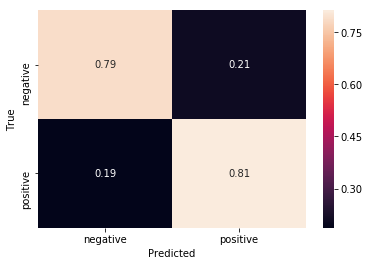

In [34]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");